**Разбор способа отбора модлеи - L2-регуляризация**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

from IPython.display import clear_output

# Источники

- https://www.statlearning.com/ 6 глава.

# Описание

При L2-регуляризации в целевую функцию метода оценки коэффициентов добавляют компоненнту:

$$\lambda\sum_{j=1}^n\beta^2_j$$

Где:
- $\beta_j$ - оцениваемый коэффициент;
- $\lambda$ - параметр указывающий на сколько сильно следует регуляризовать модель.


L2-регуляризация и регуляризация, в принципе, нужна для того, чтобы модель получала штраф за использование коэффициентов, которые ей на самом деле не нужны.

# Гребеньковая регрессия

## *Описание*

L2-регулялизация в сочетании с регрессионной моделью, называются **гребеньковой регрессией (ridge regression)**. Т.е. целевая функция в задаче оптимизации принимает вид:

$$\sum_{i=1}^n\left(y_i - x_i\beta\right)^2 + \lambda\sum_{j=1}^p\beta_j \rightarrow min$$

Где:
- $n$ - объемы выборки;
- $p$ - размерность данных;
- $x_i = (x_{i1}, x_{i2}, ..., x_{ip})$ - вектор описывающий $i$-е наблюдение;
- $\beta = (\beta_1, \beta_2, ..., \beta_p)$ - вектор оценок коэффициентов.

## *Рекомендуется стандартизация данных*

Перед применением Гребеньковой регрессии данные рекомендуется стандартизовать по формуле.


$$\tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n}\sum_{i=1}^n (x_{ij} - \bar{x}_{j})^2}}.$$

Где:
- $\bar{x}_{j}$ - среднее значенте по $j$-му показателю.

Подробнее о стандартизации можно узнать <a href="https://github.com/Dranikf/knowledge_bank/blob/main/machine_learning/data_transformations/standartisation.ipynb">тут</a>.

# Демонстрация "сжатия" коэффициентов
Воссоздается пример приведенный в <a href="https://www.statlearning.com/">ISLR</a>.

Загрузка данных `Credit`

In [2]:
Credit = pd.read_csv("Credit.csv", index_col = 0)

nominal_names = [
    "Gender", "Student", "Married", "Ethnicity"
]

ohe = OneHotEncoder(
    sparse = False, drop = "first"
).fit(
    Credit[nominal_names]
)

Credit = pd.concat(
    [
        pd.DataFrame(
            ohe.transform(Credit[nominal_names]),
            columns = ohe.get_feature_names_out(),
            index= Credit.index
        ),
        Credit.loc[:,~Credit.columns.isin(nominal_names)]
    ],
    axis = 1
)

X = Credit.iloc[:,:-1]
y = Credit.iloc[:, -1]

Credit.head()

,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian,Income,Limit,Rating,Cards,Age,Education,Balance
ID,,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,14.891,3606,283,2,34,11,333
2,1.0,1.0,1.0,1.0,0.0,106.025,6645,483,3,82,15,903
3,0.0,0.0,0.0,1.0,0.0,104.593,7075,514,4,71,11,580
4,1.0,0.0,0.0,1.0,0.0,148.924,9504,681,3,36,11,964
5,0.0,0.0,1.0,0.0,1.0,55.882,4897,357,2,68,16,331


Будем повышать параметр регуляризации и забирать значения коэффициентов. Процедура достаточно долгая, потому предполагается провести расчет и результаты отложить в файл.

Полученные значения коэффицентов нанасем на графики.

In [58]:
coefs_frame = pd.read_csv("l2_reg_coefs.csv", index_col = 0)

plot_var_names = ["Limit", "Rating", "Student_Yes", "Income"]
line_styles = ['-', '--', '-.', ':']

beta_0 = np.sqrt(np.sum(coefs_frame.loc[0]**2))
coefs_frame["beta_i/beta_0"] = coefs_frame.apply(
    lambda row: np.sqrt(np.sum(row**2))/beta_0,
    axis = 1
)

Text(0.5, 0, '$\\frac{||\\hat{\\beta}_{\\lambda}^R||_2}{||\\hat{\\beta}||_2}$')

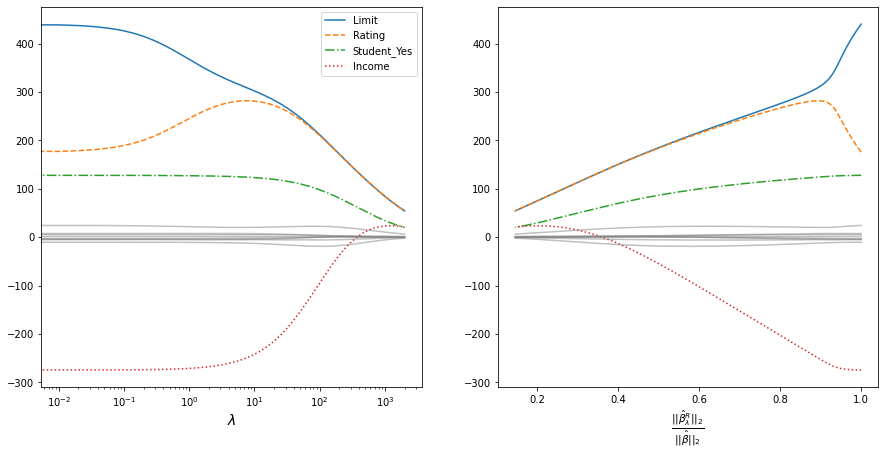

In [72]:
plt.figure(figsize = [15, 7])
plt.subplot(121)

for i in range(len(plot_var_names)):
    plt.plot(
        coefs_frame.index, 
        coefs_frame[plot_var_names[i]],
        linestyle = line_styles[i]
    )
    
for col in coefs_frame.loc[
    :, ~coefs_frame.columns.isin(plot_var_names)
]:
    plt.plot(
        coefs_frame.index, coefs_frame[col], 
        color = "gray", alpha = 0.5
    )
    
plt.legend(plot_var_names)
plt.xlabel("$\\lambda$", fontsize = 14)
    
plt.gca().set_xscale("log")

plt.subplot(122)

for i in range(len(plot_var_names)):
    plt.plot(
        coefs_frame["beta_i/beta_0"], 
        coefs_frame[plot_var_names[i]],
        linestyle = line_styles[i]
    )
    
for col in coefs_frame.loc[
    :, ~coefs_frame.columns.isin(plot_var_names)
]:
    plt.plot(
        coefs_frame["beta_i/beta_0"], coefs_frame[col], 
        color = "gray", alpha = 0.5
    )

plt.xlabel(
    "$\\frac{||\\hat{\\beta}_{\\lambda}^R||_2}{||\\hat{\\beta}||_2}$",
    fontsize = 15
)

- На графике слева показано как сходятся коэффициенты при увеличении параметра регуляризации. Для наглядности взята логарифмическая шкала для параметра регуляризации. Цветом и стилем линии выделены самые заметные коэффициенты - данные стандартизованы, потому масштаб величин не имеет занчения;
- На графике справа по ординате отложена верличина:

$$\frac{||\hat{\beta}_{\lambda}^R|_2}{||\hat{\beta}||_2}$$

Где:
- $||\beta||_2 = \sqrt{\sum_{j=1}^p \beta^2_j}$ - евклидово расстояние коэффициентов $\beta$ от начала координат;
- $\hat{\beta}$ - коэффициенты получаемые по методу наименьших квадратов (эквивалентны коэффициентам полученным при $\lambda = 0$);
- $\hat{\beta}^R_{\lambda}$ - коэффициенты полученные при использовании регуляризации.

# Смещение, диспесия и ошибка

Утверждается, что регуляризация положительно влияет на свойства модели потому, что достигается более точный баланс между дисперсией и смещением. Убедимся в этом воспроизведя вычисленный эксперимент предложенный в <a href="https://www.statlearning.com/">ISLR</a>.

In [94]:
np.random.seed(10)
n = 50; p = 45


X = np.random.rand(n, p)
y = np.dot(X, np.random.rand(p)) + np.random.normal(0, 0.003, n)

lambdas = np.arange(0, 1000, 0.1)
quadr_error = []

for lambda_ in lambdas:
    model = Ridge(alpha = lambda_).fit(X,y)
    quadr_error.append(np.sum((y - model.predict(X))**2)/n)

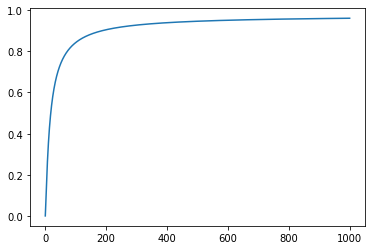

In [95]:
plt.plot(lambdas, quadr_error)